## 0.1. imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Import Data

In [2]:
# #!/bin/bash
# !curl -L -o ./archive.zip\
# https://www.kaggle.com/api/v1/datasets/download/barelydedicated/bank-customer-churn-modeling

In [3]:
data = pd.read_csv('data/Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2. Clean & preprocess data

## 2.1 Clean data and check DataFrame for missing or duplicated values

In [4]:
df = data.copy()
df.drop(columns= ['RowNumber', 'Surname'], inplace= True)
df.set_index('CustomerId', inplace= True)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 2.2 Preprocess pipeline

In [8]:
target = 'Exited'

X = df.copy().drop(columns=target)
y = df.copy()[target]


num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(include='object').columns
num_features

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

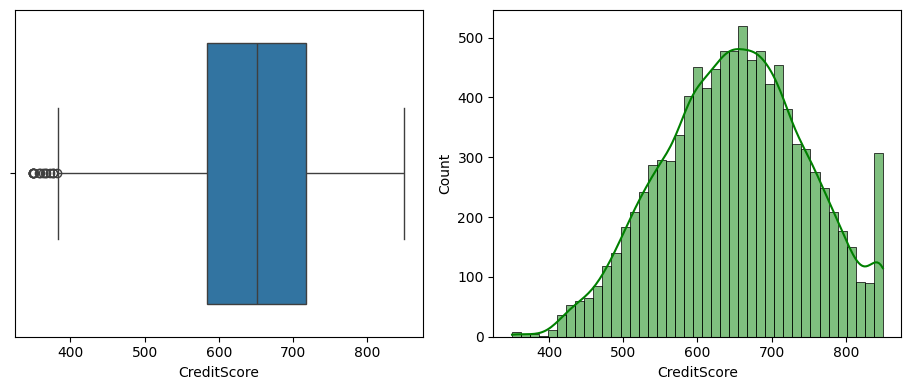

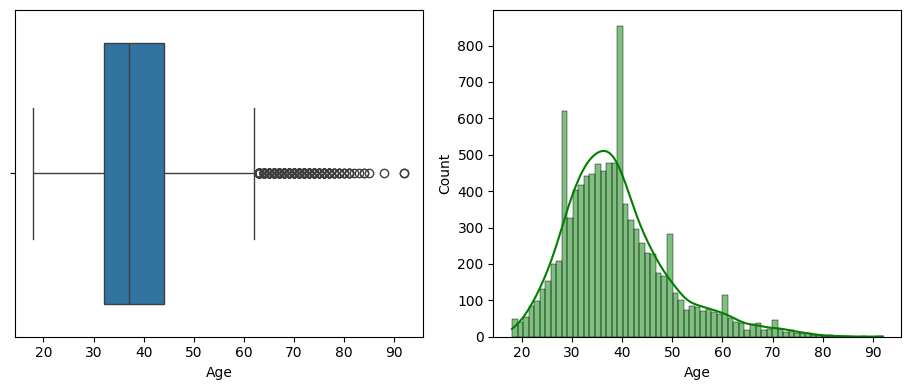

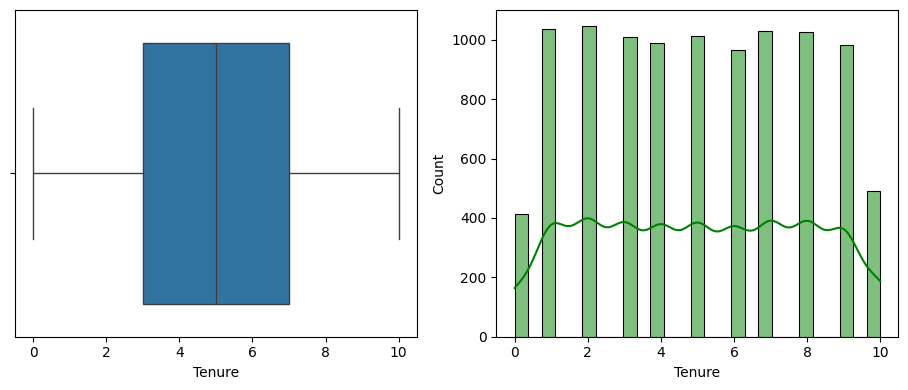

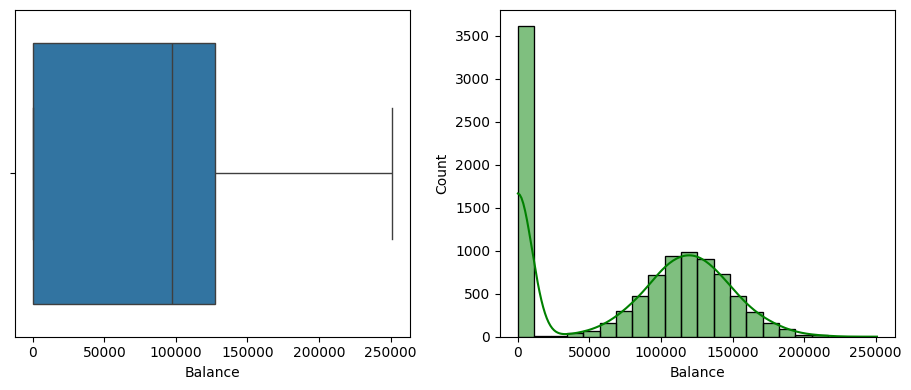

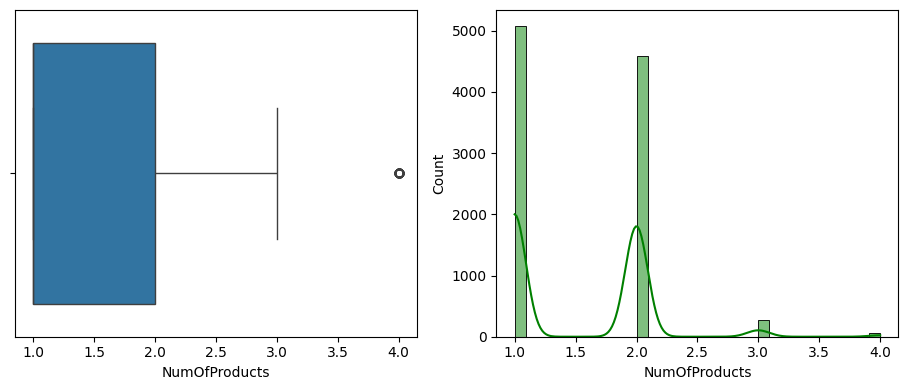

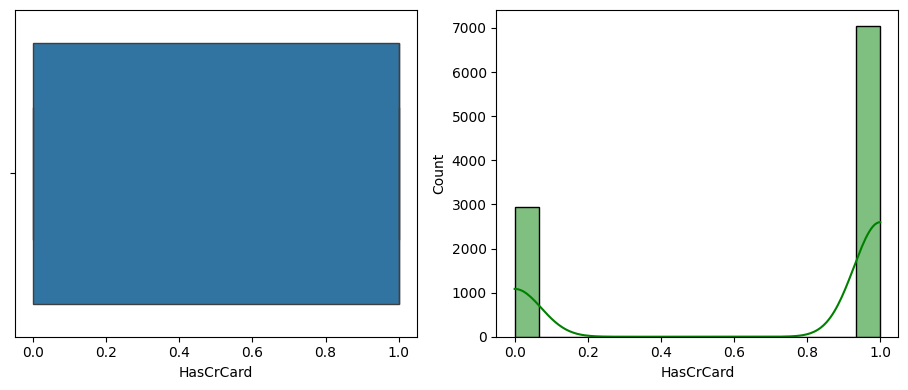

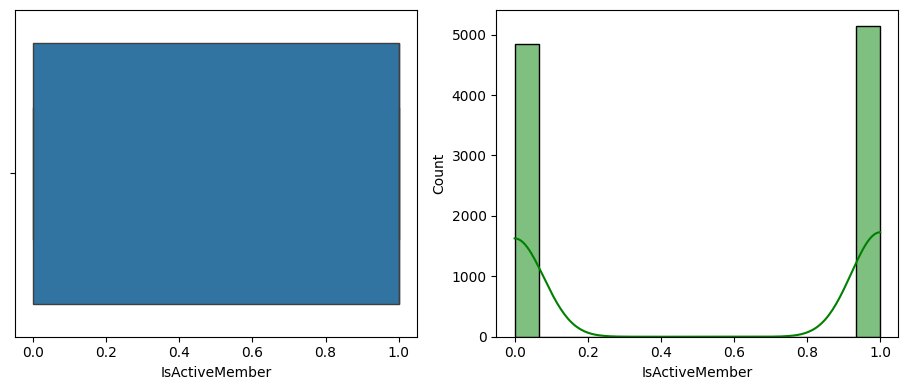

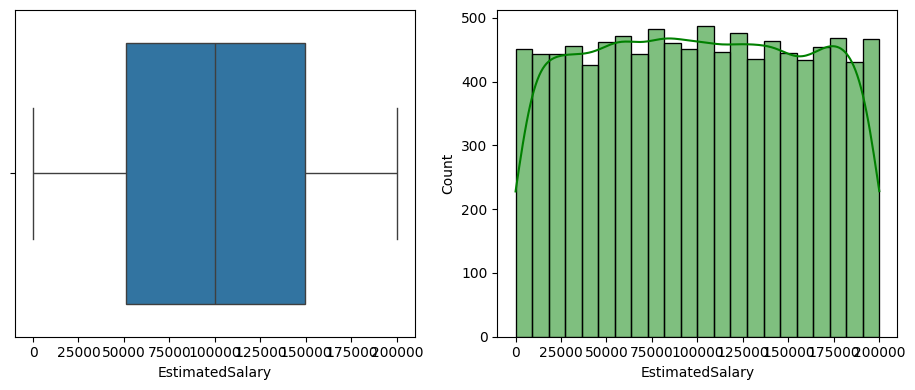

In [9]:
# Check distribution of features
from statsmodels.graphics.gofplots import qqplot

for col in num_features:
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    sns.boxplot(data=X, x=col)
    plt.subplot(1,3,2)
    sns.histplot(data=X, x=col, color='green', kde= True)
    # plt.subplot(1,3,3)
    # qqplot(data=X[col], line='s')
    plt.tight_layout()

In [10]:
y.value_counts(normalize= True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, make_union, Pipeline

num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder(
                                 sparse_output= False,
                                 drop='if_binary',
                                 handle_unknown='ignore'
                             ))

preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
    remainder='drop'
    )

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Geography', 'Gender'], dtype='object'))])

# 3. Baseline model

In [38]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, LearningCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state= 42)

X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train),\
    columns=preprocessor.get_feature_names_out())

pipeline_dummy = make_pipeline(preprocessor, DummyClassifier())

cv_results_dummy = cross_validate(pipeline_dummy, X_train, y_train,cv= 10, n_jobs= -1)
cv_results_dummy

{'fit_time': array([0.15540671, 0.15980816, 0.06032133, 0.0600884 , 0.05917239,
        0.16603661, 0.16218853, 0.06412363, 0.06084585, 0.05949664]),
 'score_time': array([0.03115654, 0.04764342, 0.01754785, 0.01822758, 0.0205667 ,
        0.01904678, 0.01822925, 0.01856256, 0.01920724, 0.02053118]),
 'test_score': array([0.79142857, 0.79142857, 0.79142857, 0.79285714, 0.79285714,
        0.79285714, 0.79285714, 0.79285714, 0.79285714, 0.79285714])}

(0.5, 1.0)

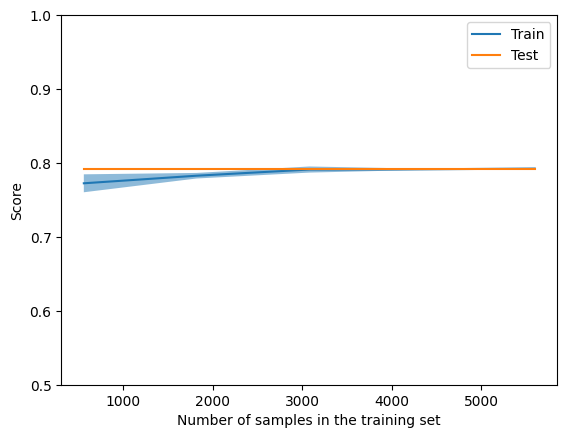

In [33]:
LearningCurveDisplay.from_estimator(pipeline_dummy, X_train, y_train)
plt.ylim(0.5,1)

In [40]:
pipeline_logreg = make_pipeline(preprocessor, LogisticRegression())
pipeline_logreg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('logisticregression', LogisticRegression())])

In [ ]:

cv_results_logreg = cross_validate(pipeline_logreg, X_train, y_train, scoring= ['accuracy', 'precision', 'recall'],cv= 5, n_jobs= -1)
cv_results_logreg

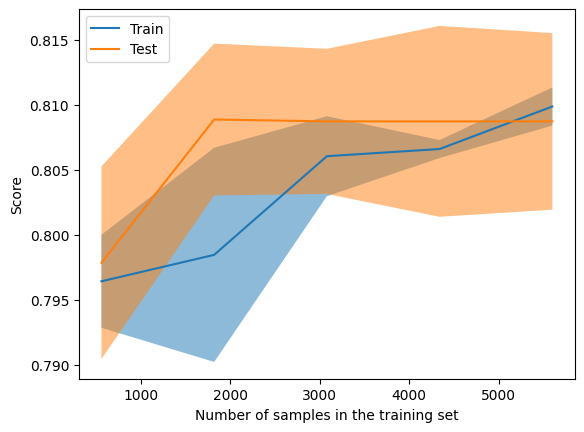

In [39]:
LearningCurveDisplay.from_estimator(pipeline_logreg, X_train, y_train)